In [9]:

import os

# 定义文件夹名称
datafolder = "data/gauss/"

# 检查文件夹是否存在
if not os.path.exists(datafolder):
    # 如果不存在，则创建文件夹
    os.makedirs(datafolder)
    print(f"文件夹 '{datafolder}' 已创建")
else:
    # 如果存在，则不做任何事情
    print(f"文件夹 '{datafolder}' 已存在")


文件夹 'data/gauss/' 已创建


# 1D Gauss

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm
def save_data_to_file(mean, std, n, N, datafile="data/gauss/gauss_1d.npz"):
    """
    将所有图对应的data数据保存到文件中
    
    参数:
    mean (list): 每个图像的均值列表
    std (list): 每个图像的标准差列表
    n (int): 图像的数量
    N (int): 每个图像对应的数据点个数
    """
    # 创建一个空的numpy数组来存储所有图像的数据
    all_data = np.zeros((len(mean_list) * len(std_list) * n, N))
    
    # 遍历所有可能的mean和std参数组合
    i = 0
    means = []
    stds = []
    Ns = []
    for mean in mean_list:
        for std in std_list:
            # 为每个参数组合生成n个图像的数据
            for _ in range(n):
                all_data[i, :] = np.random.normal(mean, std, N)
                means.append(mean)
                stds.append(std)
                Ns.append(N)
                i += 1

    # 将数据保存到文件中
    np.savez(datafile, all_data=all_data, means=means, stds=stds, Ns=Ns)
    print(f'Data saved to {datafile}')


def load_data_from_file(datafile="data/gauss/gauss_1d.npz"):
    """
    从文件中加载数据,并返回数据以及对应的统计参数
    
    参数:
    datafolder (str): 数据文件所在的文件夹路径
    filename (str): 数据文件名
    
    返回:
    all_data (numpy.ndarray): 所有图像的数据
    means (numpy.ndarray): 每个图像数据的均值
    stds (numpy.ndarray): 每个图像数据的标准差
    Ns (numpy.ndarray): 每个图像数据的数据点个数
    """
    # 从文件中加载数据
    data = np.load(datafile)
    all_data = data['all_data']
    means = data['means']
    stds = data['stds']
    Ns = data['Ns']
    
    return all_data, means, stds, Ns

# 示例用法
datafile = datafolder + "gauss_1d.npz"
mean_list = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]
std_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n = 1 # 同样参数的图有n个
N = 1000000
save_data_to_file(mean_list, std_list, n, N, datafile)

Data saved to data/gauss/gauss_1d.npz


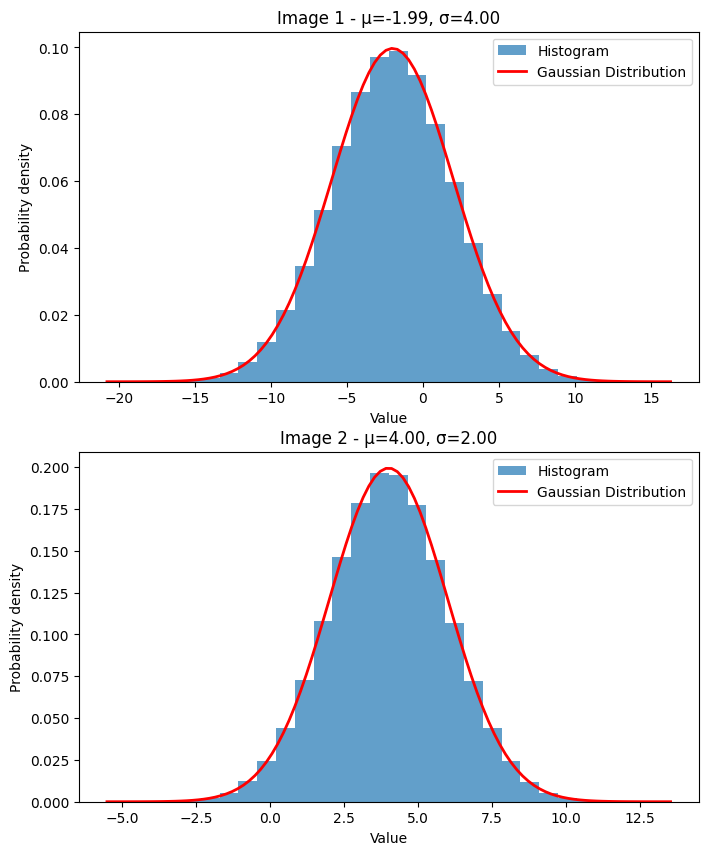

In [11]:
all_data, means, stds, Ns = load_data_from_file(datafile)

m = len(Ns)

# 绘制前两张图
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

for i in range(2):
    j = np.random.randint(m)

    # 获取第j张图的数据,随机
    data = all_data[j, :]
    mean = means[j]
    std = stds[j]
    N = Ns[j]
    
    # 生成高斯分布曲线的x轴
    x = np.linspace(data.min(), data.max(), 100)
    
    # 计算数据的均值和标准差
    mean_sample = np.mean(data)
    std_sample = np.std(data)
    
    # 绘制直方图
    axes[i].hist(data, bins=30, density=True, alpha=0.7, label='Histogram')
    
    # 绘制高斯分布曲线
    axes[i].plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label='Gaussian Distribution')
    
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Probability density')
    # axes[i].set_title(f'Image {i+1}')
    axes[i].set_title(f'Image {i+1} - μ={mean_sample:.2f}, σ={std_sample:.2f}')
    axes[i].legend()
    axes[i].grid(False)

plt.show()

# 2D

In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from functools import partial

import time
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Execution time: {:.2f} seconds".format(execution_time))
        return result, execution_time
    return wrapper

def check_model(model):
    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"num_params: {num_params}")
    is_cuda = next(model.parameters()).is_cuda
    if is_cuda:
        device_name = torch.cuda.get_device_name(0)
        memory_allocated = torch.cuda.memory_allocated(0) / 1024 ** 3  #GB
        memory_cached = torch.cuda.memory_reserved(0) / 1024 ** 3  # GB
        print(f"memory on {device_name}")
        print(f"memory_allocated: {memory_allocated:.2f} GB")
        print(f"memory_cached: {memory_cached:.2f} GB")


In [13]:

def generate_gaussian_images(batch_size, H, W, device='cpu'):
    """
    生成一批具有随机高斯分布参数的二维图像
    
    参数:
    batch_size (int): 批大小
    H (int): 图像高度
    W (int): 图像宽度
    device (str): 运行设备, 默认为 'cpu'
    
    返回:
    images (torch.Tensor): 形状为 (batch_size, H, W) 的图像张量
    mu_x (torch.Tensor): 形状为 (batch_size,) 的 x 方向均值
    mu_y (torch.Tensor): 形状为 (batch_size,) 的 y 方向均值
    sigma_x (torch.Tensor): 形状为 (batch_size,) 的 x 方向标准差
    sigma_y (torch.Tensor): 形状为 (batch_size,) 的 y 方向标准差
    """
    # 生成随机中心点，rand默认范围为[0,1)
    # x = torch.rand(batch_size, device=device) * W #[0,W)
    # y = torch.rand(batch_size, device=device) * H #[0,H)
    
    # 生成随机高斯分布参数
    mu_x = torch.rand(batch_size, device=device) * W # [0,W)
    mu_y = torch.rand(batch_size, device=device) * H # [0,H)
    sigma_x = torch.rand(batch_size, device=device) * (W / 4) + (W / 8) # [W/8,W/4]
    sigma_y = torch.rand(batch_size, device=device) * (H / 4) + (H / 8) # [H/8,H/4]
    
    # 生成二维高斯分布图像
    xx, yy = torch.meshgrid(torch.arange(W, device=device), torch.arange(H, device=device))
    images = torch.exp(-((xx[None, :, :] - mu_x[:, None, None])**2 / (2 * sigma_x[:, None, None]**2) +
                        (yy[None, :, :] - mu_y[:, None, None])**2 / (2 * sigma_y[:, None, None]**2))) / \
             (2 * np.pi * sigma_x[:, None, None] * sigma_y[:, None, None])
    
    return images.unsqueeze(1), mu_x, mu_y, sigma_x, sigma_y


In [14]:
# 生成 10,000 组数据并保存
num_samples = 10000
batch_size = 100
H, W = 28, 28

images, mu_x, mu_y, sigma_x, sigma_y = [], [], [], [], []
for _ in range(num_samples // batch_size):
    batch_images, batch_mu_x, batch_mu_y, batch_sigma_x, batch_sigma_y = generate_gaussian_images(batch_size, H, W)
    images.append(batch_images)
    mu_x.append(batch_mu_x)
    mu_y.append(batch_mu_y)
    sigma_x.append(batch_sigma_x)
    sigma_y.append(batch_sigma_y)

images = torch.cat(images, dim=0)
mu_x = torch.cat(mu_x, dim=0)
mu_y = torch.cat(mu_y, dim=0)
sigma_x = torch.cat(sigma_x, dim=0)
sigma_y = torch.cat(sigma_y, dim=0)
params = torch.cat([mu_x.unsqueeze(1), mu_y.unsqueeze(1), sigma_x.unsqueeze(1), sigma_y.unsqueeze(1)], dim=1)


print(images.shape, params.shape)

#train test split
split_ratio = 0.8
split_point = int(len(images) * split_ratio)
train_images, test_images = images[:split_point], images[split_point:]
train_params, test_params = params[:split_point], params[split_point:]

# 分成两个文件存储：

# data = torch.load('gaussian_data.pt')
# images = data['images']
# params = data['params']
torch.save({'images': train_images, 'params':train_params}, datafolder + 'train_data.pt')
torch.save({'images': test_images, 'params':test_params}, datafolder +'test_data.pt')





torch.Size([10000, 1, 28, 28]) torch.Size([10000, 4])


In [15]:
data = torch.load('train_data.pt')
images = data['images']
params = data['params']
print(images.shape)
print(params.shape)
data = torch.load('test_data.pt')
images = data['images']
params = data['params']
print(images.shape)
print(params.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'train_data.pt'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# 从文件中读取数据

class GaussianImageDataset(Dataset):
    def __init__(self, file_path):
        data = torch.load(file_path)
        self.images = data['images']
        self.params = data['params']

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        return self.images[idx], self.params[idx]

# Create the DataLoader


class GaussianImageDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=False):
        collate_fn = self.get_collate_fn()
        super().__init__(
            dataset=dataset,
            batch_size=batch_size,
            collate_fn=collate_fn,
            shuffle=shuffle,
        )
    
    def get_collate_fn(self):
        def collate_fn(batch):
            # list of tuples of tensor, convert to tensor:
            images, params = zip(*batch) 
            # 2 tuples of tensor: (B, [C, H, W]), (B, [6])
            # convert to tensor: [B, C, H, W], [B, 6]
            images = torch.stack(images, dim=0)
            params = torch.stack(params, dim=0)
    
            batch  = (images, params) # 1 tuple of tensor: ([B, C, H, W], [B, 6])
            return batch
        return collate_fn
    
train_dataset = GaussianImageDataset('train_data.pt')
batch_size = 16
data_loader = GaussianImageDataLoader(
    train_dataset,
    batch_size=batch_size,
)

for batch in data_loader:
    images, params = batch
    # Do something with the batch data
    print(f"Batch shape: images={images.shape}, params={params.shape}")


   
test_dataset = GaussianImageDataset('test_data.pt')
batch_size = 16
data_loader = GaussianImageDataLoader(
    test_dataset,
    batch_size=batch_size,
)

for batch in data_loader:
    images, params = batch
    # Do something with the batch data
    print(f"Batch shape: images={images.shape}, params={params.shape}")


Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: images=torch.Size([16, 1, 28, 28]), params=torch.Size([16, 4])
Batch shape: